In [56]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from time import time
from pyDOE import lhs
import scipy.io

In [57]:
torch.set_default_dtype(torch.float)   #torch.float => float32

torch.manual_seed(1234)   # random number generator

np.random.seed(1234)      #orther libraries' random number generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda':
    print('Our GPU :', torch.cuda.get_device_name())

Our GPU : NVIDIA GeForce GTX 1660 Ti


# Tunning Parameters

In [58]:
steps = 20000
lr = 1e-3
layers = np.array([2, 32, 32, 1])   # Hidden layers

# To generate new data:

x_min = 0
x_max = 10
t_min = 0
t_max = 10

total_points_x = 200
total_points_t = 100

# Number of training points => Nu
# Number of collocation points (Evaluate PDE) => Nf

Nu = 100
Nf = 10000


# Auxiliary Function

In [59]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="seismic")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="seismic")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [86]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')  
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  ax.view_init(30, 135)
  plt.show()

# Problem Setup

**Advection equation**

$$\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0$$

$$x\in[0, 10]$$
$$t\in[0, 10]$$

$For$ $c$ $= 1$

### Initial Condition:

$$u(x,0) = \exp(x-2)(x-2)$$

### Boundary Conditions:

$$u(0, t) = 0$$
$$u(10, t) = 0$$

In [61]:
class FCN(nn.Module):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_x=f_x_t[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f=f_t+f_x
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss   

In [62]:
def f_real(x, t):
    return torch.exp(x-t)

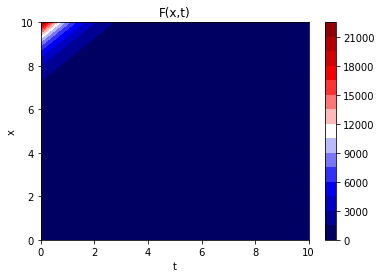

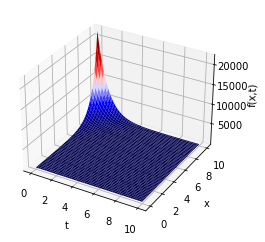

In [63]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X, T)
plot3D(x, t,y_real) #f_real was defined previously(function)

In [64]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


In [65]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([0., 0.]) tensor([10., 10.])


In [66]:
#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)
#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)
#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

In [67]:
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([200, 100]) torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


In [68]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution 


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''



FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


"\n'L-BFGS Optimizer'\noptimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, \n                              max_iter = steps, \n                              max_eval = None, \n                              tolerance_grad = 1e-05, \n                              tolerance_change = 1e-09, \n                              history_size = 100, \n                              line_search_fn = 'strong_wolfe')"

In [69]:
optimizer.step(PINN.closure)

tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)

In [70]:
start_time = time()

for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())
    
print('Elapse : ' ,time() - start_time)    

Training Loss-----Test Loss
0.34595227 --- 1387014.5
0.19182338 --- 1386968.5
0.016716238 --- 1386948.9
0.010146989 --- 1386961.8
0.008909558 --- 1386973.4
0.008563045 --- 1386973.4
0.008350511 --- 1386976.9
0.00821478 --- 1386980.4
0.008087142 --- 1386981.6
0.007864115 --- 1386981.4
Elapse :  193.491539478302


In [71]:
y1=PINN(X_test)

In [72]:
x1=X_test[:,0]
t1=X_test[:,1]

In [73]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

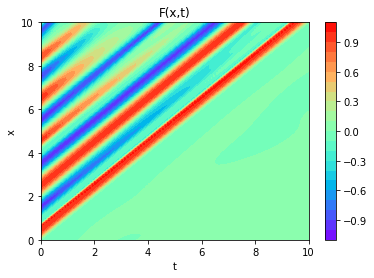

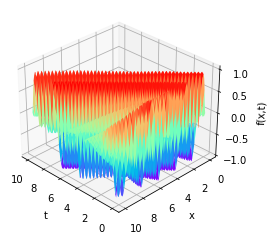

In [87]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

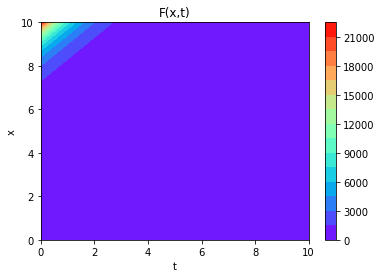

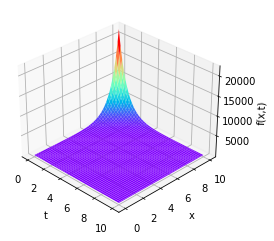

In [85]:
plot3D_Matrix(X,T,y_real)